# Simulator PV Valle_de_la_Luna_II

- Author: Victor Muñoz
- Collaborator: Nicolás Otárola
- Pvlib_version: 0.6.3
- Date : 06-01-2022 

In [53]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Photovoltaic systems
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# functions AND system photovoltaic
import sys
sys.path.append('../')
sys.path.append('../../')

import functions as func
import Valle_de_la_Luna_II_config as pv

import imp
imp.reload(pv)
imp.reload(func)

# save graphics
%matplotlib inline
%matplotlib notebook



## 1) Location , Module, Inverter, System and Model

In [54]:
#Location
loc = Location(latitude=pv.Location['lat'],
               longitude=pv.Location['long'],
               tz=pv.Location['tz'],
               altitude=pv.Location['alt'])

In [55]:
#module
module_325 = pd.Series(pv.JAM60S03,
                       name=pv.JAM60S03['Name'])

In [56]:
#inverter
inverter_1600_A = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])
inverter_1600_B = pd.Series(pv.MV_Power_Station_1600SC,
                            name=pv.MV_Power_Station_1600SC['Name'])

In [57]:
#System
system_A = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_A,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

system_B = PVSystem(module_parameters=module_325,
                    inverter_parameters=inverter_1600_B,
                    surface_azimuth=pv.System['azimuth'],
                    surface_tilt=pv.System['tilt'],
                    modules_per_string=pv.System['m_p_s'],
                    strings_per_inverter=pv.System['s_p_i'])

In [58]:
#model
mc_A = ModelChain(system_A, loc, 
                  aoi_model= 'physical' ,      # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_A")             # system_A

mc_B = ModelChain(system_B, loc,
                  aoi_model="physical",        # physical
                  spectral_model="no_loss",    # no_loss
                  dc_model='cec',              # cec or pvwatts
                  ac_model = 'pvwatts',        # snlinverter by pvwatts
                  temp_model='sapm',           # sapm
                  losses_model="pvwatts",      # pvwatts
                  name="system_B")             # system_B

## 2) Data Weather Solcast and Generacion solar

In [59]:
# Weather Solcast
path = '../Solcast/-25.406494_-70.480303_Solcast_PT60M.csv'
solcast = func.weather_solcast(path)
times, weather = func.get_times_weather(solcast,loc)

In [60]:
# Generacion solar

# Leer excel para generar pickle.
#name_excel = 'Generacion MWh plantas solar.xlsx'
#excel = pd.read_excel(name_excel)
#excel.to_pickle("Generacion MWh plantas solar")

# Leer picke una vez ya creado
data_pickle = pd.read_pickle('../Real_Generations')
name_pv = 'PMGD PFV VALLE DE LA LUNA II'
data_sub = data_pickle.loc[data_pickle['Central'] == name_pv]

In [1]:
data = func.filter_day_by_year(2020, data_sub)
data = [x*100 for x in data['Total']]

NameError: name 'func' is not defined

## 3) Simulate

In [62]:
# Run model
mc_A.run_model(times=times, weather=weather)
mc_B.run_model(times=times, weather=weather)

/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/solarposition.py:347: FutureWarning: casting datetime64[ns, America/Santiago] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  unixtime = np.array(time.astype(np.int64)/10**9)
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:425: RuntimeWarning: invalid value encountered in true_divide
  V[idx_z] = a[idx_z] * np.log1p((IL[idx_z] - I[idx_z]) / I0[idx_z]) - \
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:433: RuntimeWarning: invalid value encountered in multiply
  argW = (I0[idx_p] / (Gsh[idx_p] * a[idx_p]) *
/Users/nicolasotarolateillier/miniconda3/envs/clone/lib/python3.8/site-packages/pvlib/singlediode.py:447: RuntimeWarning: divide by zero encountered in log
  logargW = (np.log(I0[idx_p]) - np.log(Gsh[idx_p]) -
/Users/nicolasotarolate

ModelChain: 
  name: system_B
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: pvwatts_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: pvwatts_losses

## 4) Graphics

<IPython.core.display.Javascript object>


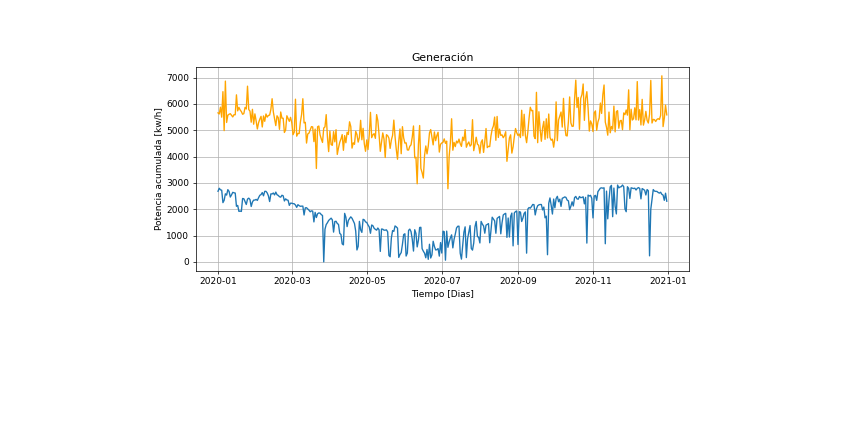

In [63]:
x_d ,y_d_a = func.get_daily_axes_from_modelChain_object(mc_A, 'System_A')
_ ,y_d_b = func.get_daily_axes_from_modelChain_object(mc_B, 'System_B')

y_d = [a+b for a,b in zip(y_d_a,y_d_b)]

func.plot_2(x=x_d,
          y=y_d,
          y2=data,
          size=(12,6),
          save='si',
          name_file='Valle_de_la_Luna_II_dias',
          color='orange',
          title='Generación',
          x_label='Tiempo [Dias]',
          y_label='Potencia acumulada [kw/h]')


In [49]:
def filter_hour_by_year(data_sub, year):
    #names = [i for i in data_sub]
    names = ['Fecha', 'Hora 1', 'Hora 2', 'Hora 3', 'Hora 4', 'Hora 5', 'Hora 6', 'Hora 7', 'Hora 8', 'Hora 9', 'Hora 10', 'Hora 11', 'Hora 12', 'Hora 13', 'Hora 14', 'Hora 15', 'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19', 'Hora 20', 'Hora 21', 'Hora 22', 'Hora 23', 'Hora 24']
    #print(names)
    filter_data = data_sub.loc[data_sub['año'] == year]
    #print(filter_data)
    long = len(filter_data)
    days = []
    arr = []
    for i in range(long):
        for j in range(len(names)):
            if (names[j] == 'Fecha'):
                f = filter_data['Fecha'].iloc[i]
                
            else:
                h = names[j]
                print(f)
                print(h)
                v = filter_data[names[j]].iloc[i]
                print(v)
                
                #days.append()
                #valor = filter_data[names[j]].iloc[i]
                #dic[filter_data['Fecha'].iloc[i]].append()
                #print(filter_data[names[j]].iloc[i])

        
#filter_hour_by_year(data_sub,2020)

<IPython.core.display.Javascript object>


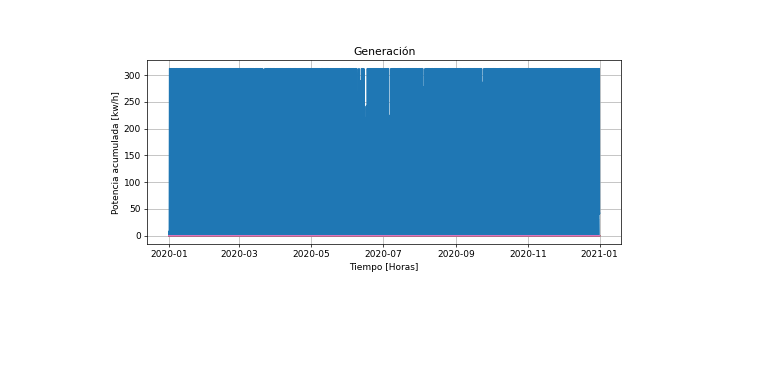

In [68]:
# falta modificar la data de entrda para que se grafique por hora

func.plot_1(x=mc_A.ac.iloc[0:].index,
          y=mc_A.ac.iloc[0:].values,
          size=(12,6),
          save='si',
          name_file='Valle_de_la_Luna_II_horas',
          color='none',
          title='Generación',
          x_label='Tiempo [Horas]',
          y_label='Potencia acumulada [kw/h]')


<IPython.core.display.Javascript object>


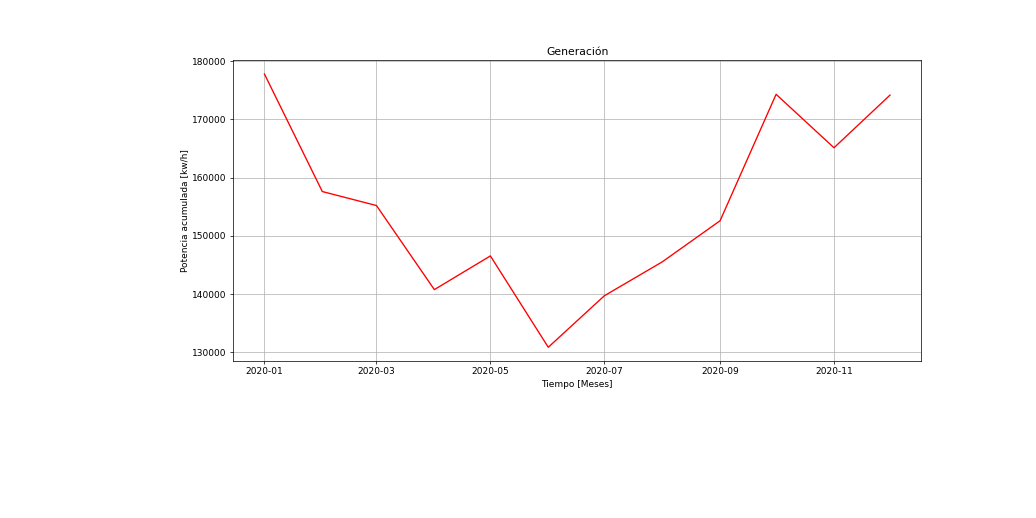

In [64]:
#falta modificar la data de entrada para que se grafique por hora
x_m, y_m_a = func.get_monthly_axes_from_modelChain_object(mc_A,'System_A')
_, y_m_b = func.get_monthly_axes_from_modelChain_object(mc_B,'System_B')

y_m = [a+b for a,b in zip(y_m_a,y_m_b)]

func.plot_1(x=x_m,
          y=y_m,
          size=(16,8),
          save='si',
          name_file='Valle_de_la_Luna_II_meses',
          color='red',
          title='Generación',
          x_label='Tiempo [Meses]',
          y_label='Potencia acumulada [kw/h]')


## Extra functions

In [16]:
textos_modulos = ['JA_Solar','325',''] # tienen que ser 3 textos
textos_inversores = ['1600','',''] # tiene que ser 3 textos
c = func.buscador(textos_inversores,textos_modulos)

for a in c:
    print(a,": ",c[a],"\n")

modulos_cec :  ['JA_Solar_Holding_JAP6_72_325_4BB', 'JA_Solar_Holdings_JAM6_k__72_325_4BB', 'JA_Solar_Holdings_JAP6_72_325_4BB', 'JA_Solar_Holdings_JAP6_72_325_4BB_RE', 'Shanghai_JA_Solar_Technology_JAM6_72_325_SI', 'Shanghai_JA_Solar_Technology_JAP6_72_325_3BB'] 

modulos_sandia :  [] 

inversores_cec :  ['Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_', 'Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Outdoor__450V__450V__CEC_2018_', 'Power_Electronics__FS1600CU__400V__400V__CEC_2018_', 'Power_Electronics__FS1600CU15__645V__645V__CEC_2018_'] 

inversores_sandia :  ['Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_', 'Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Outdoor__450V__450V__CEC_2018_', 'Power_Electronics__FS1600CU__400V__400V__CEC_2018_', 'Power_Electronics__FS1600CU15__645V__645V__CEC_2018_'] 



In [17]:
pvlib.pvsystem.retrieve_sam('cecinverter').Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_

Vac          4.500000e+02
Paco         1.600000e+06
Pdco         1.625300e+06
Vdco         9.880000e+02
Pso          3.235010e+03
C0          -5.431050e-09
C1           1.370760e-05
C2           1.178140e-03
C3           7.015790e-04
Pnt          9.000000e+01
Vdcmax       1.110000e+03
Idcmax       1.645040e+03
Mppt_low     8.920000e+02
Mppt_high    1.110000e+03
Name: Ingeteam_Power_Technology__Ingecon_Sun_1600TL_U_B615_Indoor__450V__450V__CEC_2018_, dtype: float64